# Are Relations Relevant in CNNs? *A Study Based on a Facial Dataset*

## FCN with Features Closer Together *(30 Epochs - 14 Layers)*

### Imports, Seed, GPU integration

In [1]:
import numpy as np
import random
import tensorflow as tf

In [2]:
# Seeds for better reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

In [3]:
from tensorflow.keras.layers import  Dropout, Conv2D, GlobalMaxPooling2D, BatchNormalization, Activation, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.models import Sequential
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [4]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


### Data preparation

In [5]:
train_path = '../../picasso_dataset/FCT-data/middle/train'
valid_path = '../../picasso_dataset/FCT-data/middle/valid'
test_path = '../../picasso_dataset/FCT-data/middle/test'

In [6]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['no_face', 'face'], batch_size=20)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['no_face', 'face'], batch_size=10)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['no_face', 'face'], batch_size=10, shuffle=False)

Found 16002 images belonging to 2 classes.
Found 998 images belonging to 2 classes.
Found 3000 images belonging to 2 classes.


In [7]:
assert train_batches.n == 16002
assert valid_batches.n == 998
assert test_batches.n == 3000
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2

### Building and training the FCN

In [8]:
dropout_rate=0.2

In [9]:
model = Sequential(name = "FCN-FCT")

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3), name = "Conv_1"))
model.add(MaxPool2D(pool_size=(2, 2), name = "Max_1"))
model.add(Dropout(rate=dropout_rate, name = "DO_1"))
model.add(BatchNormalization(name = "BN_1"))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same', name = "Conv_2"))
model.add(MaxPool2D(pool_size=(2, 2), name = "Max_2"))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'same', name = "Conv_3"))
model.add(MaxPool2D(pool_size=(2, 2), name = "Max_3"))
model.add(Dropout(rate=dropout_rate, name = "DO_3"))

model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding = 'same', name = "Conv_4"))
model.add(MaxPool2D(pool_size=(2, 2), name = "Max_4"))

# Fully connected layer
model.add(Conv2D(filters=2, kernel_size=(1,1), name = "Conv_con"))
model.add(GlobalMaxPooling2D(name = "GMax_con"))
model.add(Activation('softmax', name = "Act_con"))

model.summary()
untrained_weights = list(model.get_weights()[0][0][0][0])

Model: "FCN-FCT"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
Max_1 (MaxPooling2D)         (None, 112, 112, 32)      0         
_________________________________________________________________
DO_1 (Dropout)               (None, 112, 112, 32)      0         
_________________________________________________________________
BN_1 (BatchNormalization)    (None, 112, 112, 32)      128       
_________________________________________________________________
Conv_2 (Conv2D)              (None, 112, 112, 64)      18496     
_________________________________________________________________
Max_2 (MaxPooling2D)         (None, 56, 56, 64)        0         
_________________________________________________________________
Conv_3 (Conv2D)              (None, 56, 56, 128)       7385

In [10]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'] )

In [11]:
history = model.fit(x=train_batches,
          steps_per_epoch=len(train_batches),
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          epochs=30,
          verbose=2 )

Epoch 1/30
801/801 - 42s - loss: 0.6405 - accuracy: 0.6027 - val_loss: 0.5148 - val_accuracy: 0.7826
Epoch 2/30
801/801 - 42s - loss: 0.2914 - accuracy: 0.8766 - val_loss: 0.1691 - val_accuracy: 0.9379
Epoch 3/30
801/801 - 41s - loss: 0.1555 - accuracy: 0.9384 - val_loss: 0.0983 - val_accuracy: 0.9589
Epoch 4/30
801/801 - 42s - loss: 0.1043 - accuracy: 0.9594 - val_loss: 0.0840 - val_accuracy: 0.9709
Epoch 5/30
801/801 - 42s - loss: 0.0786 - accuracy: 0.9691 - val_loss: 0.0603 - val_accuracy: 0.9749
Epoch 6/30
801/801 - 41s - loss: 0.0642 - accuracy: 0.9744 - val_loss: 0.0512 - val_accuracy: 0.9770
Epoch 7/30
801/801 - 42s - loss: 0.0566 - accuracy: 0.9766 - val_loss: 0.0442 - val_accuracy: 0.9780
Epoch 8/30
801/801 - 41s - loss: 0.0470 - accuracy: 0.9798 - val_loss: 0.0336 - val_accuracy: 0.9850
Epoch 9/30
801/801 - 42s - loss: 0.0402 - accuracy: 0.9815 - val_loss: 0.0456 - val_accuracy: 0.9820
Epoch 10/30
801/801 - 41s - loss: 0.0393 - accuracy: 0.9811 - val_loss: 0.0359 - val_accura

### Saving the model

In [12]:
filename='models/FCN-FCT-30E-14L-03.h5'

In [13]:
model.save(filename)
saved_weights = list(model.get_weights()[0][0][0][0])

### Loading the saved model

In [14]:
loaded_model = load_model(filename)
loaded_weights = list(loaded_model.get_weights()[0][0][0][0])

In [15]:
# Assertion that the model was saved and loaded successfully
assert untrained_weights != saved_weights
assert saved_weights == loaded_weights

### Accuracy and loss of the trained model

In [16]:
scores = loaded_model.evaluate(test_batches, verbose=2)
print("Accuracy: %.2f%%" % (scores[1]*100))
print("Loss: %.2f%%" % (scores[0]*100))

300/300 - 7s - loss: 0.0206 - accuracy: 0.9867
Accuracy: 98.67%
Loss: 2.06%


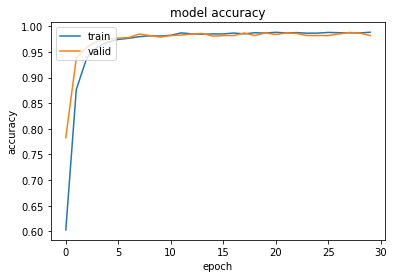

In [17]:
#Course of accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

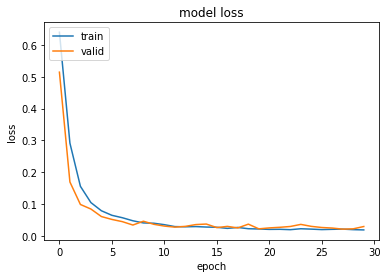

In [18]:
#Course of loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

### Testing the CNN

In [19]:
predictions = loaded_model.predict(x=test_batches, steps=len(test_batches), verbose=0)

### Index of wrongly predicted pictures

In [20]:
y_true=test_batches.classes
y_pred=np.argmax(predictions, axis=-1)
cm = confusion_matrix(y_true = y_true, y_pred = y_pred)

In [21]:
face_but_predicted_no_face=[]
no_face_but_predicted_face=[]

for i in range(len(predictions)):
        if y_true[i] != y_pred[i]:
            if y_true[i] == 1:
                face_but_predicted_no_face.append(i+8001-1500) #Index of file on disk
            else:
                no_face_but_predicted_face.append(i+8001) #Index of file on disk

print("Data from class 'face', that was wrongly predicted as 'no-face' [", len(face_but_predicted_no_face), "] :")
print(face_but_predicted_no_face)
print("----------------------------------------------------------------------------------------------")
print("Data from class 'no-face', that was wrongly predicted as 'face' [", len(no_face_but_predicted_face), "] :")
print(no_face_but_predicted_face)

Data from class 'face', that was wrongly predicted as 'no-face' [ 0 ] :
[]
----------------------------------------------------------------------------------------------
Data from class 'no-face', that was wrongly predicted as 'face' [ 40 ] :
[8014, 8229, 8287, 8311, 8343, 8345, 8352, 8394, 8401, 8469, 8482, 8488, 8509, 8524, 8591, 8595, 8623, 8666, 8731, 8747, 8751, 8765, 8812, 8919, 8945, 8950, 8970, 8995, 9034, 9049, 9060, 9071, 9196, 9197, 9200, 9275, 9293, 9361, 9415, 9445]


### Confusion matrix

In [22]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [23]:
test_batches.class_indices

{'no_face': 0, 'face': 1}

Confusion matrix, without normalization
[[1460   40]
 [   0 1500]]


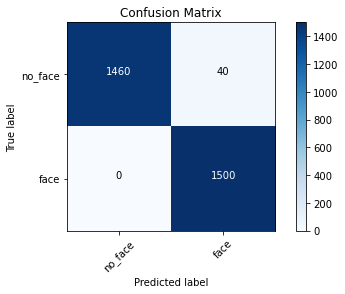

In [24]:
cm_plot_labels = ['no_face','face']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')
